In [3]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose, Resize
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
batch_size = 256

train_loader = DataLoader(MNIST('/data/', 
                                train=True, 
                                download=True, 
                                transform=Compose([ToTensor()])), 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(MNIST('/data/', 
                                train=False, 
                                download=True, 
                                transform=Compose([ToTensor()])), 
                          batch_size=10000, 
                          shuffle=True)

test_batches = enumerate(test_loader)
ids, (data, y_test) = next(test_batches)
x_test = data.view(10000, -1)

In [23]:
class Net(nn.Module):  
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.Linear(784, 128)
        self.encoder = nn.Linear(128, 2)
        self.decoder = nn.Linear(2, 128) 
        self.output = nn.Linear(128, 784)

        torch.nn.init.xavier_uniform_(self.input.weight)
        torch.nn.init.xavier_uniform_(self.encoder.weight)
        torch.nn.init.xavier_uniform_(self.decoder.weight)
        torch.nn.init.xavier_uniform_(self.output.weight)

#         torch.nn.init.xavier_uniform_(self.encoder.bias) 

        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.encoder(x))
        x = F.relu(self.decoder(x))
        return torch.sigmoid(self.output(x))
    
    def encode(self, x):
        x = F.relu(self.input(x))
        return F.relu(self.encoder(x))
    


In [27]:
net = Net()
# torch.nn.zerosnet.input
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.view(inputs.shape[0], -1)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %3d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
print('Finished')

[1, 100] loss: 0.088
[1, 200] loss: 0.065
[2, 100] loss: 0.063
[2, 200] loss: 0.062
[3, 100] loss: 0.062
[3, 200] loss: 0.061
[4, 100] loss: 0.061
[4, 200] loss: 0.061
[5, 100] loss: 0.061
[5, 200] loss: 0.061
[6, 100] loss: 0.060
[6, 200] loss: 0.060
[7, 100] loss: 0.060
[7, 200] loss: 0.059
[8, 100] loss: 0.056
[8, 200] loss: 0.053
[9, 100] loss: 0.052
[9, 200] loss: 0.052
[10, 100] loss: 0.051
[10, 200] loss: 0.050
[11, 100] loss: 0.050
[11, 200] loss: 0.049
[12, 100] loss: 0.048
[12, 200] loss: 0.048
[13, 100] loss: 0.048
[13, 200] loss: 0.047
[14, 100] loss: 0.047
[14, 200] loss: 0.047
[15, 100] loss: 0.047
[15, 200] loss: 0.046
[16, 100] loss: 0.046
[16, 200] loss: 0.046
[17, 100] loss: 0.046
[17, 200] loss: 0.046
[18, 100] loss: 0.046
[18, 200] loss: 0.045
[19, 100] loss: 0.045
[19, 200] loss: 0.045
[20, 100] loss: 0.045
[20, 200] loss: 0.045
Finished


In [28]:
decoded_imgs = net(x_test).detach().numpy()


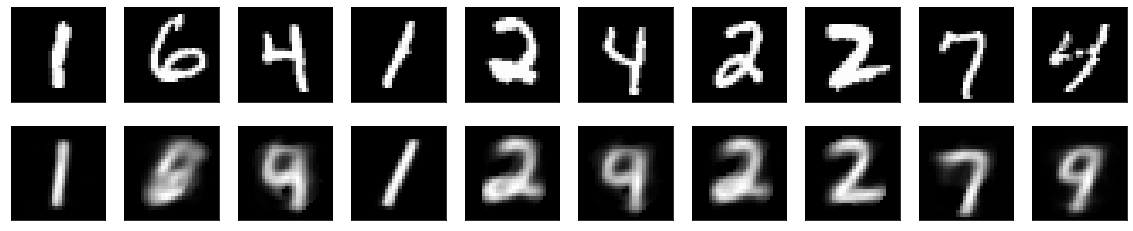

In [29]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

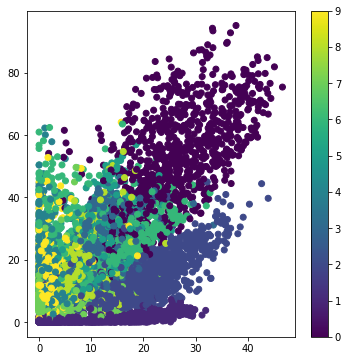

In [30]:
x_test_encoded = net.encode(x_test).detach().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# VARIATIONAL AUOTENCODER

In [5]:
class VAE(nn.Module):  
    def __init__(self):
        super(VAE, self).__init__()
        self.input = nn.Linear(784, 128)
        self.mean = nn.Linear(128, 2)
        self.variance = nn.Linear(128, 2)
        self.decoder = nn.Linear(2, 128) 
        self.output = nn.Linear(128, 784)

    def encode(self, x):
        x = F.relu(self.input(x))
        z_mean = self.mean(x)
        z_var = self.variance(x)
        return z_mean, z_var
    
    def reparametrize(self, z_mean, z_var):
        rnd = torch.randn_like(z_mean)
        return z_mean + rnd * torch.exp(0.5 * z_var)
    
    
    def decode(self, z):
        x = F.relu(self.decoder(z))
        return torch.sigmoid(self.output(x))
    
    def forward(self, x):
        z_mean, z_var = self.encode(x)
        z = self.reparametrize(z_mean, z_var)
        return self.decode(z), z_mean, z_var

In [10]:
vae = VAE()
# torch.nn.zerosnet.input
optimizer = optim.Adam(vae.parameters(), lr=0.001)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

for epoch in range(20):
    vae.train()
    train_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.view(inputs.shape[0], -1)
        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(inputs)
        loss = loss_function(recon_batch, inputs, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(train_loader.dataset),
                100. * i / len(train_loader),
                loss.item() / len(inputs)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 549.671997
Train Epoch: 0 [25600/60000 (43%)]	Loss: 208.769318
Train Epoch: 0 [51200/60000 (85%)]	Loss: 192.048340
====> Epoch: 0 Average loss: 229.9790
Train Epoch: 1 [0/60000 (0%)]	Loss: 189.139099
Train Epoch: 1 [25600/60000 (43%)]	Loss: 181.109772
Train Epoch: 1 [51200/60000 (85%)]	Loss: 185.112427
====> Epoch: 1 Average loss: 183.7367
Train Epoch: 2 [0/60000 (0%)]	Loss: 179.751556
Train Epoch: 2 [25600/60000 (43%)]	Loss: 174.642731
Train Epoch: 2 [51200/60000 (85%)]	Loss: 177.101242
====> Epoch: 2 Average loss: 176.2138
Train Epoch: 3 [0/60000 (0%)]	Loss: 176.770493
Train Epoch: 3 [25600/60000 (43%)]	Loss: 174.126068
Train Epoch: 3 [51200/60000 (85%)]	Loss: 164.507980
====> Epoch: 3 Average loss: 172.0950
Train Epoch: 4 [0/60000 (0%)]	Loss: 174.371567
Train Epoch: 4 [25600/60000 (43%)]	Loss: 163.438660
Train Epoch: 4 [51200/60000 (85%)]	Loss: 167.029297
====> Epoch: 4 Average loss: 169.1909
Train Epoch: 5 [0/60000 (0%)]	Loss: 172.083908
Train Ep

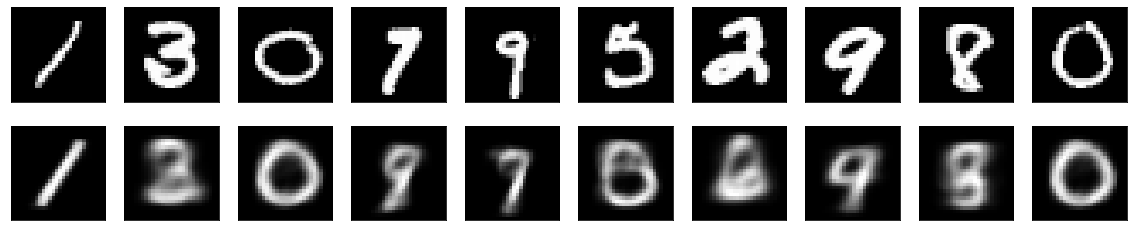

In [12]:
test_rec, _, _ = vae(x_test)
decoded_imgs = test_rec.detach().numpy()
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

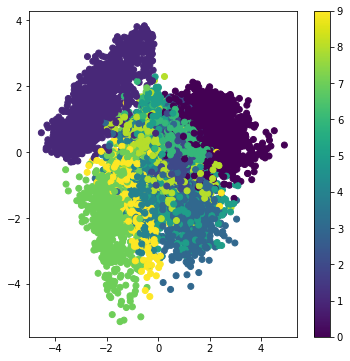

In [13]:
z_m, z_v = vae.encode(x_test)
z = vae.reparametrize(z_m, z_v)

x_test_encoded = z.detach().numpy()


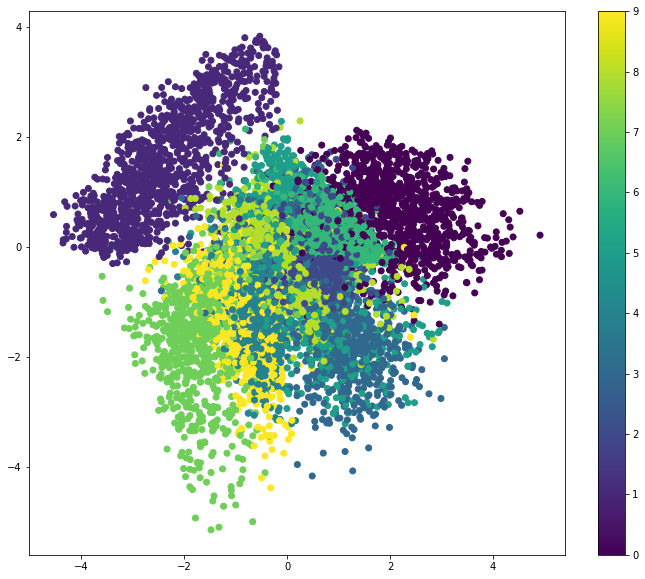

In [14]:
plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()